### Database Format
**Date**: 	 Date of accident,  in the format - January 01, 2001  
**Time**: 	 Local time, in 24 hr. format unless otherwise specified  
**Airline/Op**: 	 Airline or operator of the aircraft  
**Flight #**: 	 Flight number assigned by the aircraft operator  
**Route**: 	 Complete or partial route flown prior to the accident  
**Type**: 	 Aircraft type  
**Reg**: 	 ICAO registration of the aircraft  
**cn / ln**: 	 Construction or serial number / Line or fuselage number  
**Aboard**: 	 Total aboard (passengers / crew)  
**Fatalities**: 	 Total fatalities aboard (passengers / crew)  
**Ground**: 	 Total killed on the ground  
**Summary**: 	 Brief description of the accident and cause if known  

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re

df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
Date            5268 non-null object
Time            3049 non-null object
Location        5248 non-null object
Operator        5250 non-null object
Flight #        1069 non-null object
Route           3562 non-null object
Type            5241 non-null object
Registration    4933 non-null object
cn/In           4040 non-null object
Aboard          5246 non-null float64
Fatalities      5256 non-null float64
Ground          5246 non-null float64
Summary         4878 non-null object
dtypes: float64(3), object(10)
memory usage: 535.1+ KB


,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [3]:
def how(plane):
    fatalities, ground = plane
    if fatalities == 0 and ground == 0:
        return 'all survived'
    elif fatalities == 0 and not ground == 0:
        return 'died on the ground'
    else:
        return 'died in plane'
          
def daytime(time):
    if time >= '18:00' and time < '24:00':
        return 'evening'
    elif time >= '06:00' and time < '12:00':
        return 'morning'
    elif time >= '12:00' and time < '18:00':
        return 'day'
    elif time >= '00:00' and time < '6:00':
        return 'night'
    else:
        return np.nan

def cause(plane):
    shot = re.search("shot|Shot|hit", plane)
    weather = re.search("fog|storm|lighting|wheather|snow|mud|thunderstorm|ice|icing", plane)
    human = re.search("error|struck|sabotage", plane)
    mech = re.search("engine|wing|gear|propeller", plane)
    if shot:
        return "Shot down"
    elif weather:
        return "Weather"
    elif human:
        return "Human mistake"
    elif mech:
        return "Mechanical damage"
    else:
        return np.nan
    
f1 = open('usa_states.txt','r')
f2 = open('countries.txt','r')

us, cont = "", ""

for line in f1:
    temp = line[:-1:] + "|"
    us += temp
    
for line in f2:
    temp = line[:-1:] + "|"
    cont += temp
    
f1.close()
f2.close()

us = us[:-1:]
cont = cont[:-1:]

def country(plane):   
    us_states = re.search(us, plane)
    c = re.search(cont, plane)
    if us_states:
        return 'United States'
    elif c:
        return c.group(0)
    else:
        return np.nan
    
def how_many(plane):
    aboard, fatalities = plane
    if (aboard - fatalities > 0):
        return aboard - fatalities
    else:
        return 0
    
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df["how"] = df[["fatalities", "ground"]].apply(how, axis=1)
df['survived'] = df[["aboard", "fatalities"]].apply(how_many, axis=1)
df["daytime"] = df.time.astype(str).apply(daytime)
df['plane_type'] = df.operator.str.extract('(Military|Private)', expand=False).fillna('Passengers')
df['cause'] = df.summary.astype(str).apply(cause)
df['country'] = df.location.astype(str).apply(country)
df = df.drop(["flight_#", "summary", "cn/in", "route", "location", "registration", "type"],axis=1)
df.head()

,date,time,operator,aboard,fatalities,ground,year,month,how,survived,daytime,plane_type,cause,country
0,1908-09-17,17:18,Military - U.S. Army,2.0,1.0,0.0,1908,9,died in plane,1.0,day,Military,Mechanical damage,United States
1,1912-07-12,06:30,Military - U.S. Navy,5.0,5.0,0.0,1912,7,died in plane,0.0,morning,Military,NaN,United States
2,1913-08-06,NaN,Private,1.0,1.0,0.0,1913,8,died in plane,0.0,NaN,Private,Weather,Canada
3,1913-09-09,18:30,Military - German Navy,20.0,14.0,0.0,1913,9,died in plane,6.0,evening,Military,Weather,NaN
4,1913-10-17,10:30,Military - German Navy,30.0,30.0,0.0,1913,10,died in plane,0.0,morning,Military,Mechanical damage,Germany


So, let's see number of crushes by year.

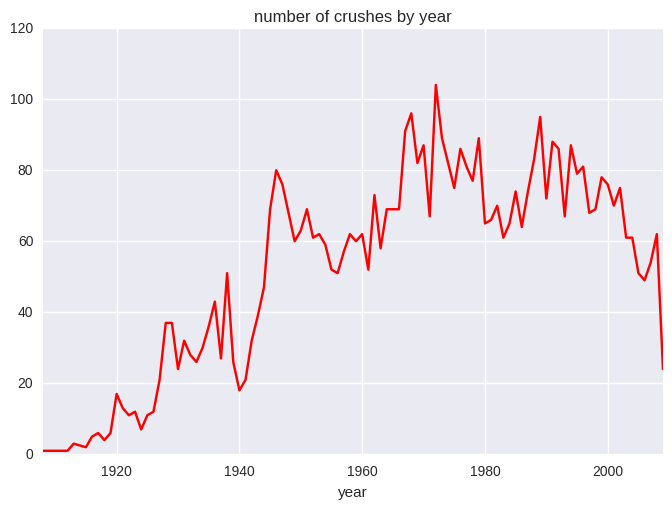

In [4]:
df.groupby('year').size().plot(title='number of crushes by year', color='red')

Now let's see info about operators.

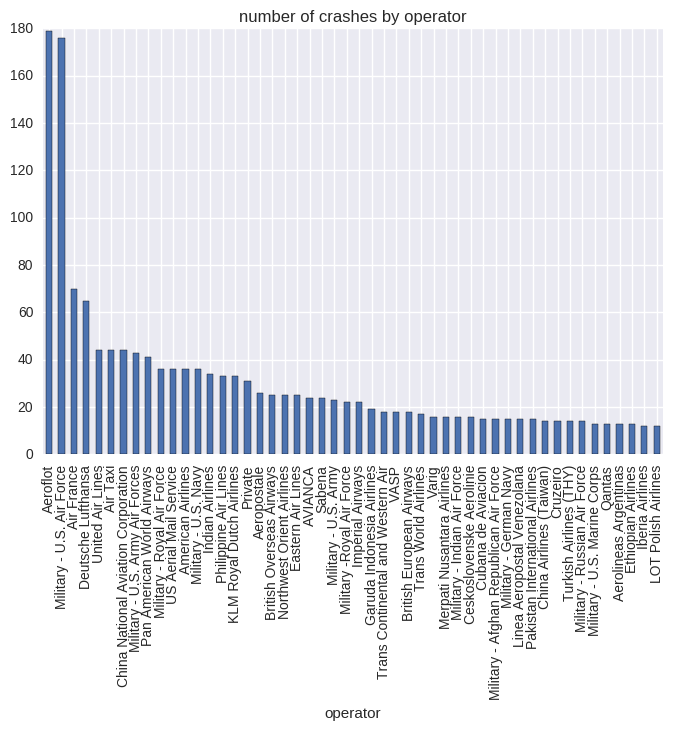

In [6]:
df.groupby("operator").size().sort_values(ascending=False)[0:50].plot(kind='bar', title='number of crashes by operator')

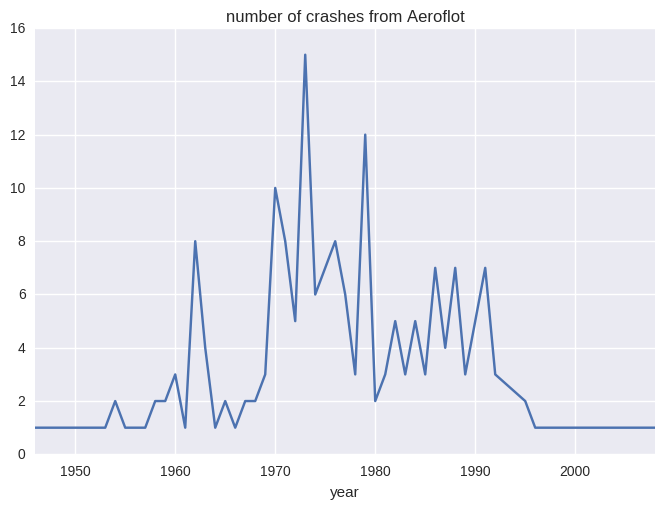

In [103]:
df.groupby('operator').get_group('Aeroflot').groupby('year').size().plot(title = 'number of crashes from Aeroflot')

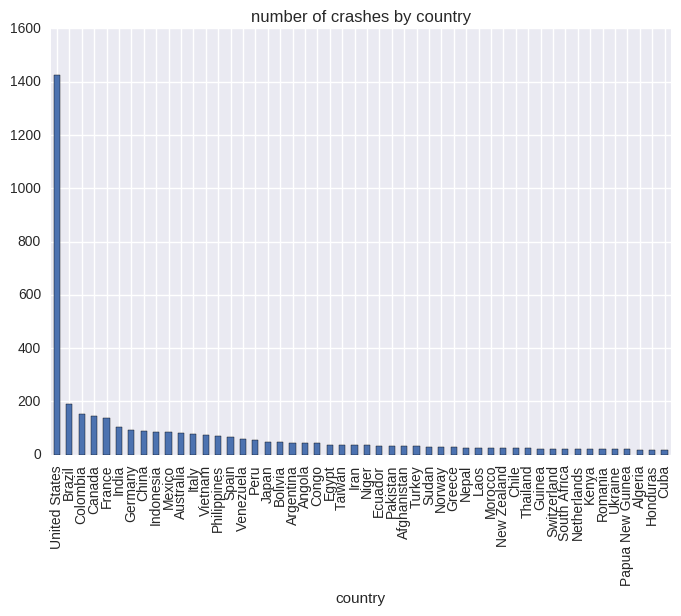

In [8]:
df.groupby("country").size().sort_values(ascending=False)[0:50].plot(kind='bar', title='number of crashes by country')

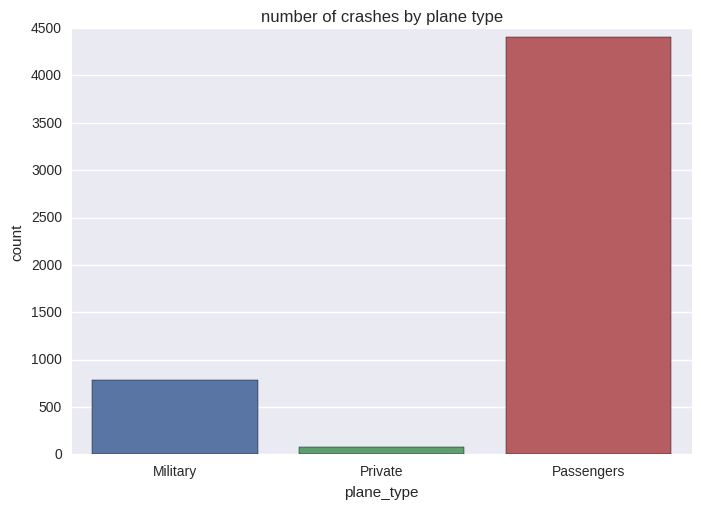

In [9]:
sb.countplot(x="plane_type", data=df)
sb.plt.title('number of crashes by plane type')

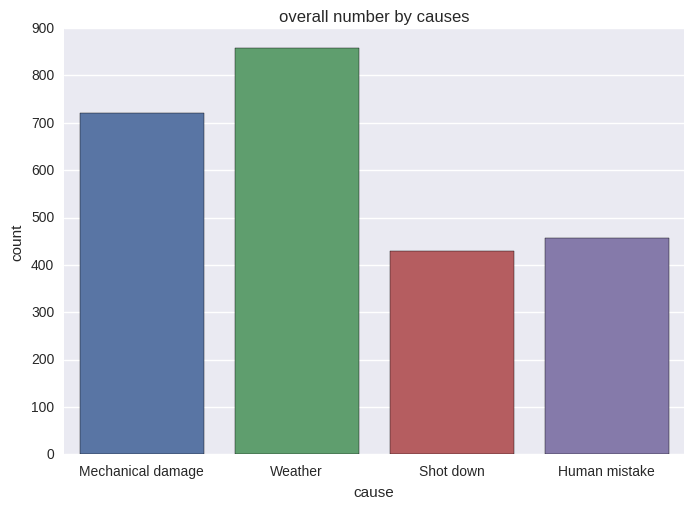

In [11]:
sb.countplot("cause", data=df)
sb.plt.title('overall number by causes')

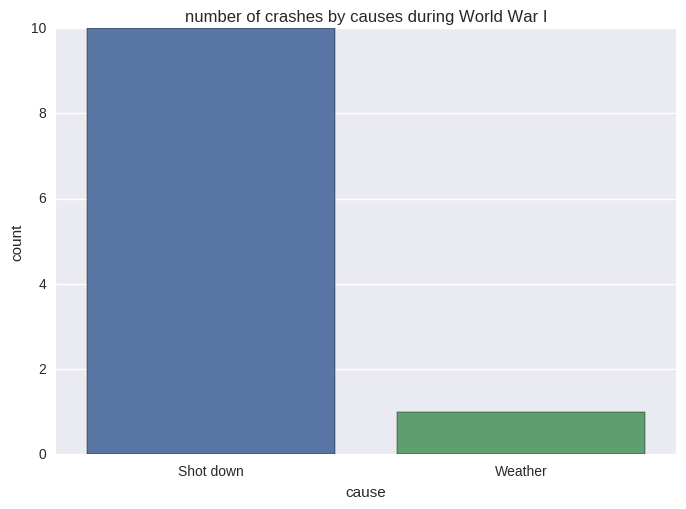

In [12]:
WWI = df[(df.year > 1913) & (df.year < 1919)]
sb.countplot("cause", data=WWI)
sb.plt.title('number of crashes by causes during World War I')

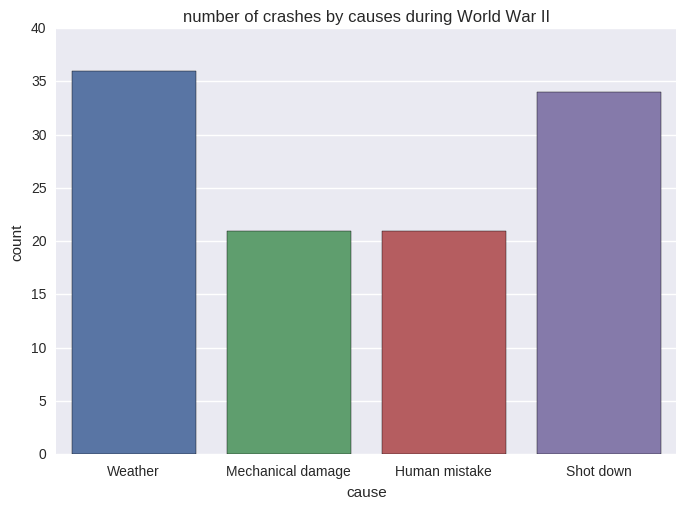

In [13]:
WWII = df[(df.year >= 1939) & (df.year <= 1945)]
sb.countplot("cause", data=WWII)
sb.plt.title('number of crashes by causes during World War II')

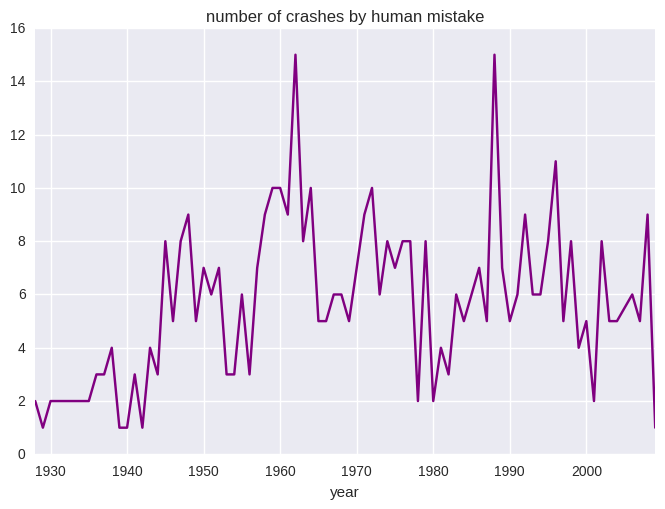

In [12]:
df[df.cause == 'Human mistake'].groupby('year').size().plot(color='purple', title='number of crashes by human mistake')

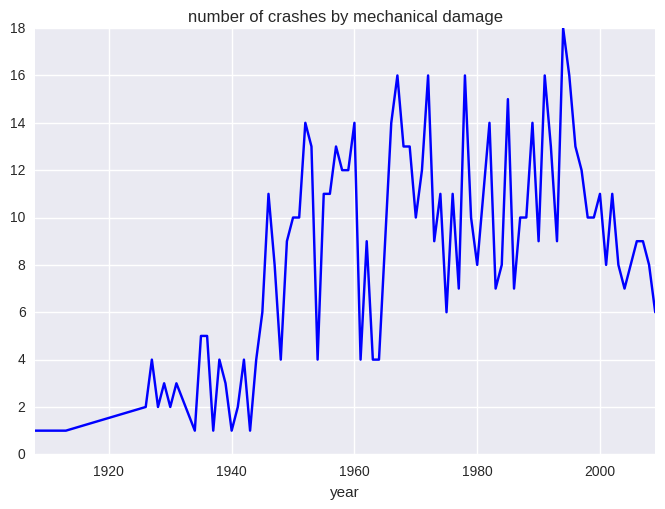

In [13]:
df[df.cause == 'Mechanical damage'].groupby('year').size().plot(color='blue', title='number of crashes by mechanical damage')

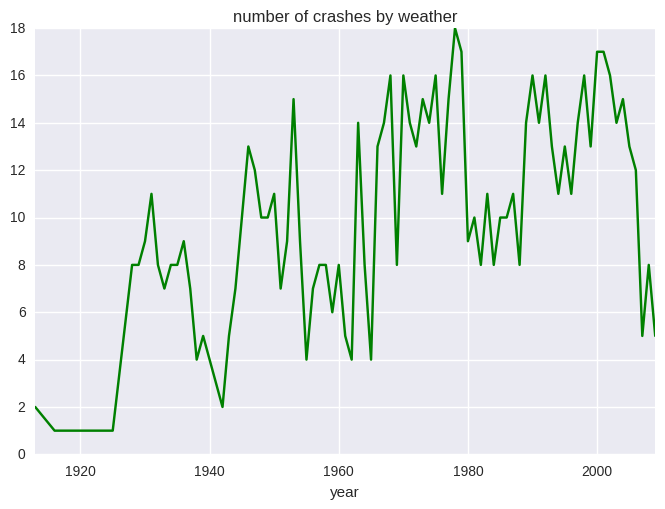

In [14]:
k3 = df[df.cause == 'Weather'].groupby('year').size().plot(color='green', title = 'number of crashes by weather')

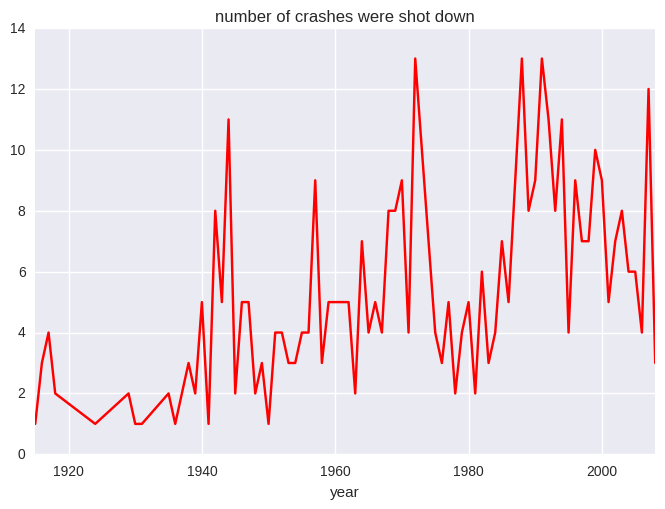

In [15]:
df[df.cause == 'Shot down'].groupby('year').size().plot(color='red', title = "number of crashes were shot down")

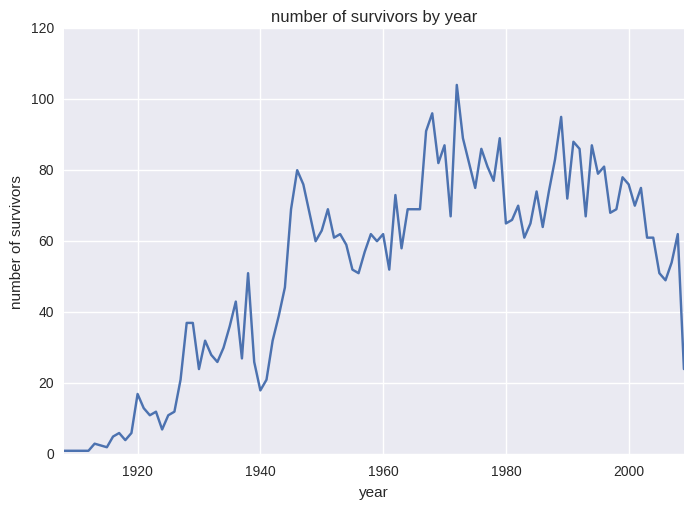

In [121]:
df[df.survived >= 0].groupby('year').size().plot(title = 'number of survivors by year')
plt.ylabel('number of survivors')
plt.xlabel('year')

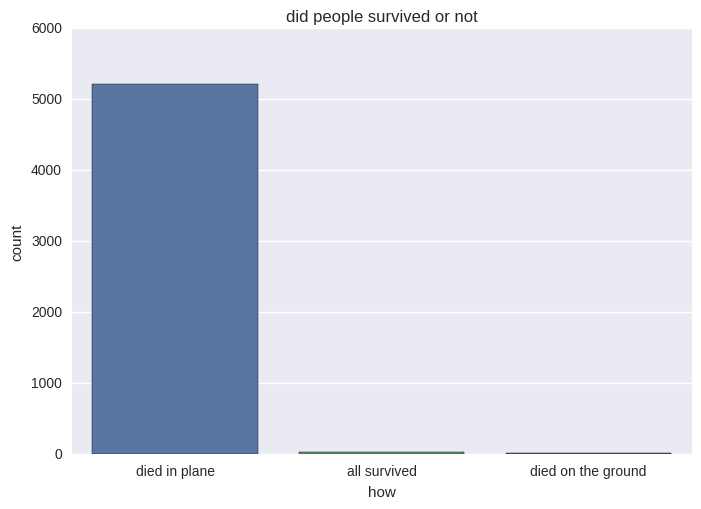

In [122]:
sb.countplot("how", data=df)
sb.plt.title('did people survived or not')

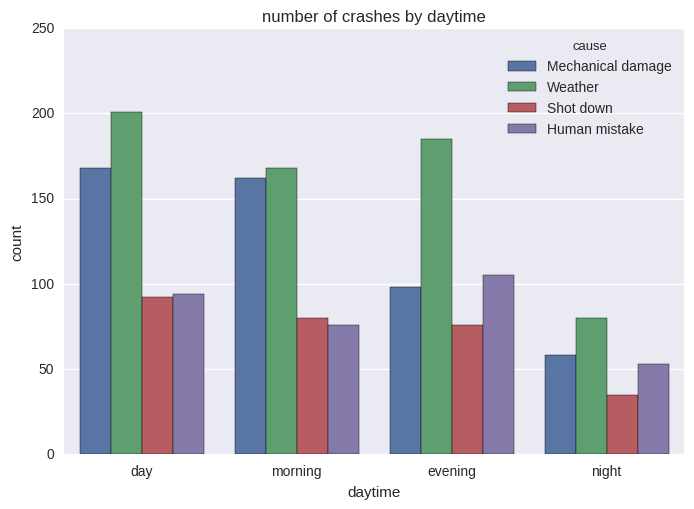

In [123]:
sb.countplot("daytime",hue="cause", data=df)
sb.plt.title('number of crashes by daytime')

In [14]:
df.to_csv('cleaned.csv')

In [15]:
d3_1 = pd.DataFrame(df.groupby("operator").size().sort_values(ascending=False)[0:50])

In [16]:
d3_1.reset_index(level=1, inplace=True)

In [17]:
d3_1.to_csv('d3_1.tsv', sep='\t',header=['operator', 'values'])

In [18]:
d3_2 = pd.DataFrame(df.groupby('year').size())
d3_2.reset_index(level=1, inplace=True)

In [19]:
d3_2.to_csv('d3_2.tsv', sep='\t',header=['year', 'values'])